# Moving-average smoothing and seasonal decomposition

We will illustrate a common approach to decomposing data into trend and seasonal components, using moving-average smoothing to calculate the trend.

This is a fairly simple analysis that will also introduce us to some basic statistics tools in Python.

First we will import the necessary packages.

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

import fredapi

from statsmodels.tsa.seasonal import seasonal_decompose

And import config information.

In [2]:
import os
from dotenv import load_dotenv
load_dotenv();

The dataset we will use is aggregate nonfarm payrolls (PAYNSA), published by the Bureau of Labor Statistics ([link](https://fred.stlouisfed.org/series/PAYNSA)).

PAYNSA is released monthly, and exhibits clear seasonality. Part of our goal in this analysis is to separate the trend and seasonality components in this data. We will compare our results with a seasonally-adjusted version of the payrolls data (PAYEMS), which is also published by BLS and follows a more complex methodology than what we will pursue here ([link](https://fred.stlouisfed.org/series/PAYEMS)).

In [3]:
PAYNSA  = fredapi.Fred().get_series('PAYNSA', 
        observation_start = '2000-01-01', observation_end = '2024-12-31', 
        frequency='m', aggregation_method='eop')
PAYNSA = PAYNSA / 1000
PAYEMS  = fredapi.Fred().get_series('PAYEMS', 
        observation_start = '2000-01-01', observation_end = '2024-12-31', 
        frequency='m', aggregation_method='eop')
PAYEMS = PAYEMS / 1000

Plot the raw data: Notice the effect of seasonal adjustment.

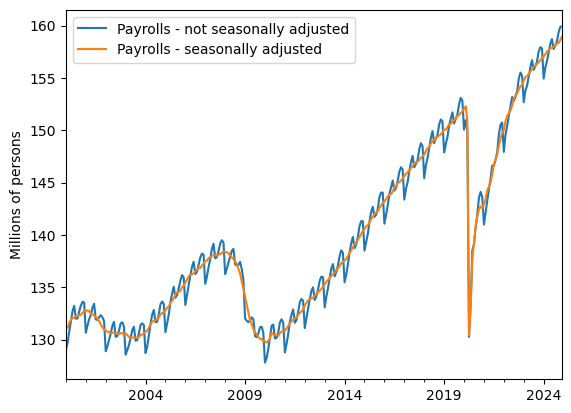

In [4]:
PAYNSA.plot(legend=True,label="Payrolls - not seasonally adjusted",ylabel="Millions of persons");

PAYEMS.plot(legend=True,label="Payrolls - seasonally adjusted");

Use the statsmodels function "seasonal_decompose" to visualize the trend and seasonal components of the raw data. It plots the raw data first, then the "trend," "seasonal," and "residual" components. We will reproduce these figures by hand to understand how they were built.

It's important to point out that this is not the only possible approach to extracting trend and cycle components from a data series. And, just because we can draw figures like this, does not necessarily mean that they are revealing anything deep about the data. For now, just think of them as tools for visualization. 

In fact, if you look very closely, you can already see one shortcoming of this simple approach to trend detection. When a major shock affects the series, such as Covid in early 2020, the "trend" that we calculate in the current approach will pick up on that even a few months early, since we average the future in with the present. As a result, you can see the "trend" in the first figure below starts to turn downward long before Covid actually affected the economy. The "residuals" in the bottom figure then overcompensate in the other direction. 

Overall, the figures tell the story that late 2019 was a time when the "trend" of the economy was already turning downward, but we had a string of lucky months that concealed that trend until things turned unlucky in early 2020. In fact a more reasonable perspective is that there was no downward trend in 2019, just a very sharp shock in 2020. But the moving-average approach is forced to think in the way described by the pictures below.

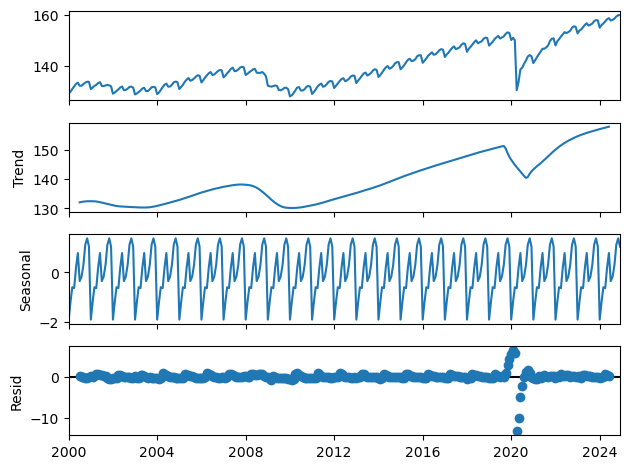

In [5]:
seasonal_decompose(PAYNSA,period=12).plot();

The rest of the code will show how to match the figures above by hand:

First, we pull out "trend" figure from above and plot it by itself:

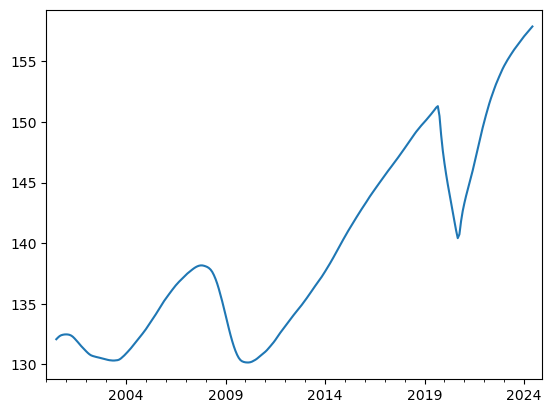

In [6]:
seasonal_decompose(PAYNSA,period=12).trend.plot();

The figure above is plotting a <b>centered moving average</b> of order $m=12$.
As described in the slides, the formula for this is
$$
CMA_t = \frac{1}{12}\left( \frac{1}{2} y_{t-6} \, + \, y_{t-5} \, + \, ... \, + \, y_{t+5} \, + \, \frac{1}{2} y_{t+6} \right)
$$
Why does the formula look this way? What we want to do is to take an average over 12 months, centered at month $t$. But these two requirements contradict each other because 12 is an even number. So the convention is to average over one extra month (so 13 months total), with only 1/2 weight on the first and last month, so that the total weights still add up to 12.

Based on this formula, we can reproduce the figure above with the following code. In the code, we use the Pandas "shift" function, which returns a modified series that is shifted backwards in time by the specified number. We can use this to capture the terms in the formula above: $y_{t-6}$ corresponds with PAYNSA.shift(6), etc. To shift forward in time you use negative numbers. 

(Notice that the command spills over multiple lines. We can do this in Python when we are inside a pair of parentheses.)

The commented line of code (starting with #) shows a shorter way of writing the same thing. For those who want to build up Python expertise, this might be useful to study. 
The code uses the function sum(), which adds up a list of numbers. 
Inside the sum function, the list of numbers is created by the bracketed expression, which is an example of a **list comprehension.** This is a condensed way of writing a loop, unique to Python. 
The example here creates a list [PAYNSA.shift(5), PAYNSA.shift(4), ...] and then the sum() adds them all up. (Notice that PAYNSA.shift(0) just returns PAYNSA with no changes.)
The range() function is the standard way to create a list of numbers in Python:

- range(x,y) will return the numbers from x *increasing* up to y, but *not including* y. For example, range(1,5) will return 1,2,3,4. If y is less than or equal to x, then range(x,y) will not include anything at all. 
- range(x,y,z) will return the numbers starting at x, ending at y (without including it), and stepping by the amount z at each step. So for example range(0,10,2) will return 0,2,4,6,8. 
- We can use z=-1 to make the function count downward. So in the case at hand, range(5,-6,-1) returns 5,4,3,2,1,0,-1,-2,-3,-4,-5.

In [7]:
PAYNSA_CMA = (1/12)*( 0.5*PAYNSA.shift(6) + PAYNSA.shift(5) + PAYNSA.shift(4) + PAYNSA.shift(3)
                    + PAYNSA.shift(2) + PAYNSA.shift(1) + PAYNSA + PAYNSA.shift(-1) + PAYNSA.shift(-2)
                    + PAYNSA.shift(-3) + PAYNSA.shift(-4) + PAYNSA.shift(-5) + 0.5*PAYNSA.shift(-6) )

# Using a list comprehension:
# PAYNSA_CMA = (1/12)*( 0.5*PAYNSA.shift(6) + sum([PAYNSA.shift(i) for i in range(5,-6,-1)]) + 0.5*PAYNSA.shift(-6) )

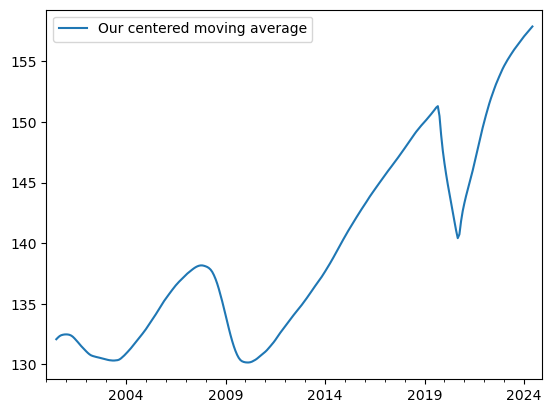

In [8]:
PAYNSA_CMA.plot(legend=True,label="Our centered moving average");

This figure exactly matches the earlier output from the seasonal_decompose() function. We can compare it with the original data series:

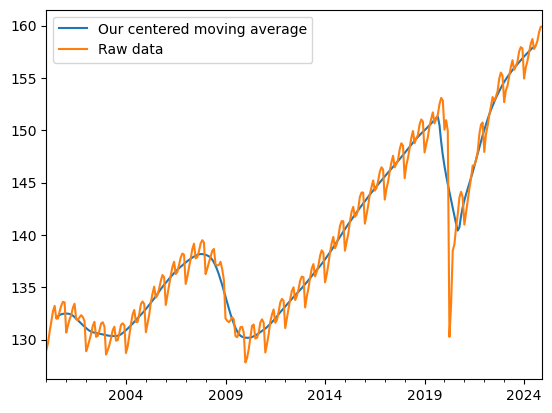

In [9]:
PAYNSA_CMA.plot(legend=True,label="Our centered moving average");
PAYNSA.plot(legend=True,label="Raw data");

We can also compare it with the BLS seasonally-adjusted series PAYEMS (see figure below). The basic pattern is the same, but you can see some clear differences as well. 

Again, there are many different potential approaches to smoothing and seasonal adjustments. The BLS approach tries very hard to separate out true "shocks" like Covid from gradual trends. The methodology is quite complicated and we will not try to explain it in detail. However, you can see they successfully avoided the problem that we encountered where the MA approach inferred a downward trend in 2019 based on the Covid shock in 2020.

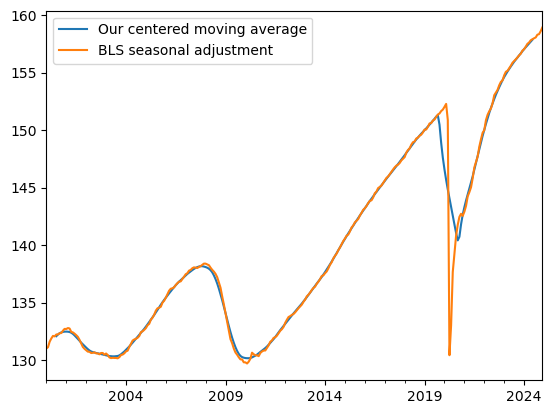

In [10]:
PAYNSA_CMA.plot(legend=True,label="Our centered moving average")
PAYEMS.plot(legend=True,label="BLS seasonal adjustment");

Now plot the "seasonal" figure that was produced by the function. 

That figure repeats itself for every year, so I will pick a specific year at random (2000) to plot.

The seasonal pattern we see is that payrolls are at their lowest at the start of the year. They grow through the spring, spike just before the start of the summer, then drop off during the summer. Finally, they rise to their highest levels at the end of the year.

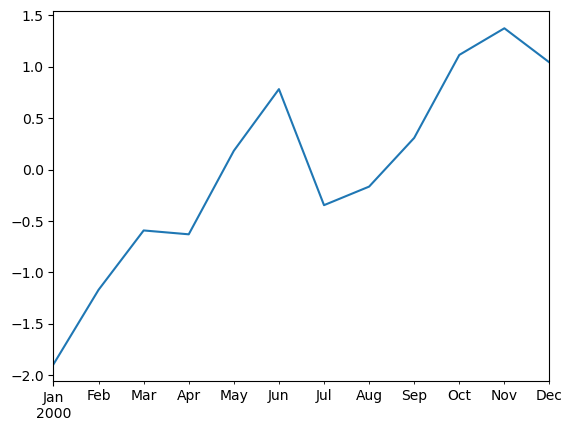

In [11]:
seasonal_decompose(PAYNSA,period=12).seasonal['2000'].plot();

We can reproduce this figure by the following process:
1. Calculate a "detrended" version of the payrolls data, as the raw data minus the CMA that we calculated above.
2. Calculate the mean of this detrended data separately for each month in the year.
3. Recenter these averages by subtracting out *their* average across all 12 months.

First calculate and visualize the "detrended" data:

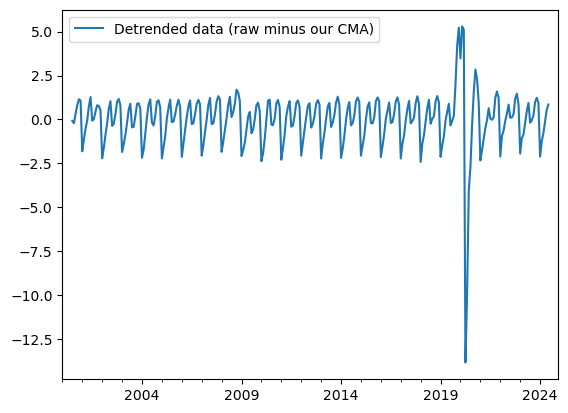

In [12]:
PAYNSA_detrend = PAYNSA - PAYNSA_CMA
PAYNSA_detrend.plot(legend=True,label="Detrended data (raw minus our CMA)");

Next calculate the seasonal component as the average value of the detrended data for each month in the year.

The loop in the code below features another example of the range() function in Python. Again notice that the second input to this function should be one *more* than the last value we want to loop over.

The commented line shows how to replace the loop with a list comprehension.

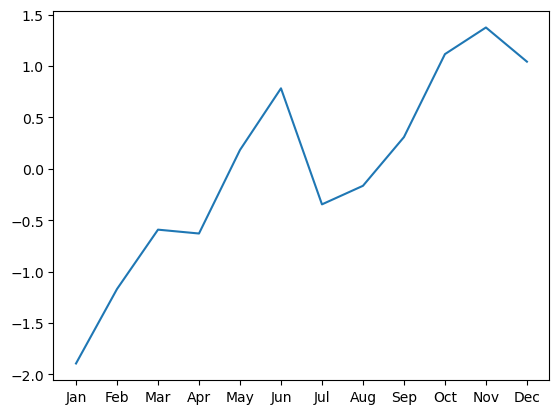

In [13]:
PAYNSA_seas = np.array(np.zeros(12))
for i in range(1,13):
    monthly_values = PAYNSA_detrend[PAYNSA_detrend.index.month == i]
    PAYNSA_seas[i-1] = monthly_values.mean()

# Using a list comprehension:
# PAYNSA_seas = np.array( [ PAYNSA_detrend[PAYNSA_detrend.index.month == i].mean() for i in range(1,13) ] )

PAYNSA_seas = PAYNSA_seas - PAYNSA_seas.mean()

plt.plot(PAYNSA_seas);
plt.xticks(ticks=[i for i in range(0,12)],labels=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']);

Finally, the "residual" figure from seasonal_decompose is just the part of the series that was not trend or seasonal. For completeness we can reproduce this figure as well.

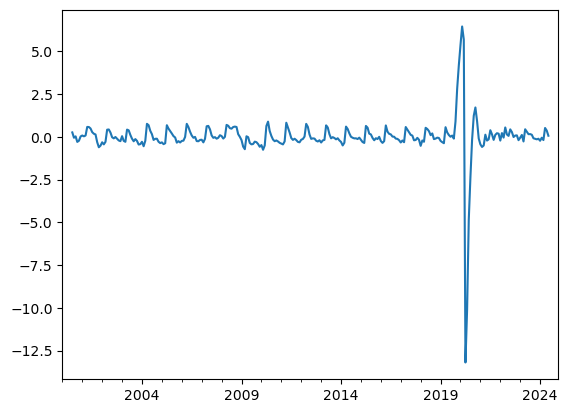

In [14]:
seasonal_decompose(PAYNSA).resid.plot();

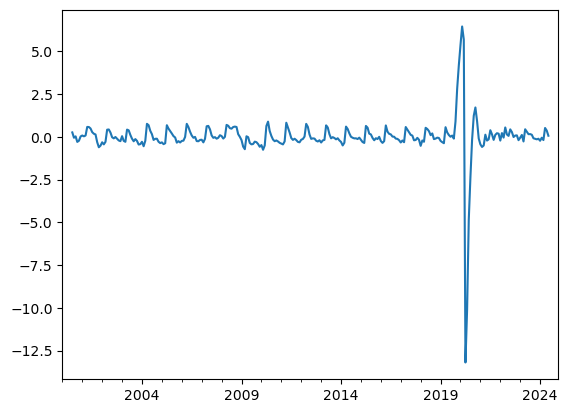

In [15]:
PAYNSA_resid = PAYNSA - PAYNSA_CMA - PAYNSA_seas[PAYNSA.index.month.values - 1]

PAYNSA_resid.plot();

In this class, we will see many off-the-shelf packages and tools that are designed to do some specific analysis for you, such as the moving-average smoothing approach from today. They can save you a lot of time, but fundamentally, they are usually doing something very simple! We will pause frequently to reproduce the main part of their output by hand, as we did just above. Even if you will not actually do this in practice, it is important to understand how these tools work behind the scenes, and to understand that there is no magic behind them.